# Deep Metric Learning
## This Notebook is a deep metric leanring approach via contrastive learning. The basis builds the tensorflow similarity package

In [1]:
import gc
import itertools
import sys

In [2]:
import cv2
import argparse
import datetime
import io
import numpy as np
import os
import pandas as pd
import pathlib
import random
import seaborn as sns
import shutil
import tensorflow as tf
import tensorflow_similarity as tfsim
from collections import Counter
from inspect import signature
from keras import activations, losses, models, optimizers
from keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from matplotlib import pyplot as plt
from pathlib import Path
from scipy import stats
from sklearn import metrics  # For loss functions
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    auc,
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow_similarity.types import Lookup, Tensor
from typing import Mapping, Optional, Sequence, Tuple
from tensorboard.plugins import projector

In [3]:
tfsim.utils.tf_cap_memory()
# Clear out any old model state.
gc.collect()
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)
%load_ext tensorboard
# For evaluation

TensorFlow: 2.8.0
TensorFlow Similarity 0.15.6


## Models, Plots, i.e. helper functions

In [18]:
# Similar model to base line, added BatchNorm, adjusted kernel_sizes, filter_sizes and pooling layers according to keras tuner
# results, only limited time ...
def CNN(embedding_size=256):
    inputs = keras.layers.Input([187,1])
    x = keras.layers.Conv1D(filters=16, kernel_size=3, strides=1)(inputs)
    x = keras.layers.Conv1D(filters=16, kernel_size=9, strides=1)(x)

    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.ReLU()(x)
    x=keras.layers.MaxPool1D(pool_size=5, strides=1)(x)

    x=keras.layers.Conv1D(filters=256, kernel_size=5, strides=1)(x)
    x=keras.layers.Conv1D(filters=92, kernel_size=9, strides=1)(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.ReLU()(x)
    x=keras.layers.MaxPool1D(pool_size=5, strides=1)(x)

    x=keras.layers.Conv1D(filters=184, kernel_size=9, strides=1)(x)
    x=keras.layers.Conv1D(filters=104, kernel_size=3, strides=1)(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.ReLU()(x)
    x=keras.layers.MaxPool1D(pool_size=5, strides=1)(x)

    x=keras.layers.Flatten()(x)
    x=keras.layers.Dense(1924, activation="relu")(x)
    outputs = tfsim.layers.MetricEmbedding(embedding_size)(x)
    model= tfsim.models.SimilarityModel(inputs, outputs)


    model.summary()

    return model


def get_data(data, data_path, zscore=True):
    if data == "mitbih":
        df_train = pd.read_csv(data_path+"/mitbih_train.csv", header=None)
        df_train = df_train.sample(frac=1)
        df_test = pd.read_csv(data_path+"/mitbih_test.csv", header=None)

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    elif data == "ptbdb":
        df_1 = pd.read_csv(data_path+"/ptbdb_normal.csv", header=None)
        df_2 = pd.read_csv(data_path+"/ptbdb_abnormal.csv", header=None)
        df = pd.concat([df_1, df_2])

        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1337, stratify=df[187])

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    if zscore:
        X = stats.zscore(X, axis=1)
        X_test = stats.zscore(X_test, axis=1)

    return X, X_test, Y, Y_test


def plot_roc(y_actual, y_pred):
    """
    Function to plot AUC-ROC curve
    """
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    plt.figure(figsize=(9, 6))
    plt.plot(
        fpr,
        tpr,
        color="b",
        label=r"Model (AUC = %0.2f)" % (roc_auc_score(y_actual, y_pred)),
        lw=2,
        alpha=0.8,
    )
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        lw=2,
        color="r",
        label="Luck (AUC = 0.5)",
        alpha=0.8,
    )
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()


def plot_precisionrecall(y_actual, y_pred):
    """
    Function to plot AUC-ROC curve
    """
    average_precision = average_precision_score(y_actual, y_pred)
    precision, recall, _ = precision_recall_curve(y_actual, y_pred)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = (
        {"step": "post"} if "step" in signature(
            plt.fill_between).parameters else {}
    )

    plt.figure(figsize=(9, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall curve: AP={0:0.2f}".format(average_precision))


def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


#plots nn of choosen sample in metric space adjusted from tensorflow similarity
def viz_neigbors_imgs(example: Tensor,
                      example_class: int,
                      neighbors: Sequence[Lookup],
                      class_mapping: Optional[Mapping[int, str]] = None,
                      fig_size: Tuple[int, int] = (24, 4),
                      cmap: str = 'viridis',
                      show: bool = True):
    """Display images nearest neighboors
    Args:
        example: The data used as query input.
        example_class: The class of the data used as query
        neighbors: The list of neighbors returned by the lookup()
        class_mapping: Mapping from class numerical ids to a class name. If not
        set, the plot will display the class numerical id instead.
        Defaults to None.
        fig_size: Size of the figure. Defaults to (24, 4).
        cmap: Default color scheme for black and white images e.g mnist.
        Defaults to 'viridis'.
        show: If the plot is going to be shown or not. Defaults to True.
    """
    num_cols = len(neighbors) + 1
    _, axs = plt.subplots(1, num_cols, figsize=fig_size)

    # draw target
    axs[0].plot(example)
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    class_label = _get_class_label(example_class, class_mapping)
    axs[0].set_title(class_label)

    for ax, nbg in zip(axs[1:], neighbors):
        val = _get_class_label(nbg.label, class_mapping)
        legend = f"{val} - {nbg.distance:.5f}"
        ax.plot(nbg.data)
        ax.set_title(legend)
        ax.set_xticks([])
        ax.set_yticks([])
    if show:
        plt.show()
    else:
        return plt


def _get_class_label(example_class, class_mapping):
    if example_class is None:
        return 'No Label'

    if class_mapping is None:
        return str(example_class)

    class_label = class_mapping.get(example_class)
    return class_label if class_label is not None else str(example_class)

# Needed for tensorboard 
def project_embedding(model, class_mappings, log_dir, X_test, Y_test, sprite_image=False):
    """
    :param model: model needed for generating embedding vector of each image
    :param class_mappings: dicts for class label corresponance
    :param log_dir:
    :return:
    The Projection in tensorbaord
    """

    # maximal image size allowed for visuallizing in tensorboard
    # Log dir of projection
    if sprite_image:
        mdir = 'validation'
        num_examples = int(1500/len([*Counter(Y_test).keys()]))
    else:
        mdir = 'train'
        num_examples = 750
    logdir = os.path.join(log_dir, mdir)
    X_test, Y_test = tfsim.samplers.select_examples(
        X_test, Y_test, [*Counter(Y_test)], num_examples)
    # genearte metadatafile needed to assign each dot /image in embedding space a lable
    metadata_file = open(os.path.join(logdir, 'metadata.tsv'), 'a+')

    metadata_file.write('Label\tClass\n')
    for i in range(len(Y_test)):
        vy = Y_test[i]
        cm = class_mappings[vy]

        metadata_file.write('{}\t{}\n'.format(cm, vy))

    if sprite_image:
        # generate sprites, for visuallization in tensorboard
        img_data = [make2d(x) for x in X_test]
        sprite = images_to_sprite(np.array(img_data))
        cv2.imwrite(os.path.join(logdir, 'sprite.png'), sprite)

    emb = model.predict(X_test)
    # Save the weights we want to analyze as a variable.
    # The weights need to have the shape (Number of sample, Total Dimensions)
    # Hence why we flatten the Tensor
    weights = tf.Variable(tf.reshape(emb, (X_test.shape[0], -1)), name="emb")
    # Create a checkpoint from embedding, the filename and key are the
    # name of the tensor.
    checkpoint = tf.train.Checkpoint(emb=weights)
    checkpoint.save(os.path.join(logdir, "embedding.ckpt"))

    # Set up config.
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = "emb/.ATTRIBUTES/VARIABLE_VALUE"
    embedding.metadata_path = 'metadata.tsv'
    if sprite_image:
        embedding.sprite.image_path = 'sprite.png'
        embedding.sprite.single_image_dim.extend(
            [133, 200])  # image size = 28x28
    # The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
    projector.visualize_embeddings(logdir, config)

# Image from plot

#transforms 2d time_series data to images(h,w,c) for later sprite images in tensorboard
def make2d(x):
    fig, ax = plt.subplots()
    ax.axis('off')
    fig.tight_layout(pad=0)
    # To remove the huge white borders
    ax.margins(0)
    plt.plot(x, linewidth=7)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    input_img_resize = cv2.resize(image_from_plot, (133, 200))
    return input_img_resize


def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding

    Args:
      data: NxHxW[x3] tensor containing the images.

    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[..., np.newaxis], (1, 1, 1, 3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1, 2, 3, 0) - min).transpose(3, 0, 1, 2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1, 2, 3, 0) / max).transpose(3, 0, 1, 2)
    # Inverting the colors seems to look better for MNIST
    # data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
               (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
                  constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
                                                           + tuple(range(4, data.ndim + 1)))
    data = data.reshape(
        (n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

#Adjusted agumentation function, augmentations are taken from https://github.com/uchidalab/time_series_augmentation
import warnings
warnings.filterwarnings('ignore')
def augment(x,y,*args):
    aug_types_list = ["jitter",
                      "scaling","rotation",
                      "permutation0","permutation1",
                      "time_warp","window_slice","window_warp"
                     ]
    x = tf.cast(x, tf.float32)
    x = x.numpy()
    augment_probability = 0.5
    augment_layers = 6
    if random.random() < augment_probability:
        how_many_augments = random.randint(1,augment_layers)
        aug_types_list = random.sample(aug_types_list,how_many_augments)
    else:
        aug_types_list=["NoAugments"]
        
    if "jitter" in aug_types_list:
        x = jitter(x)
    if "scaling" in aug_types_list:
        x = scaling(x)
    if "rotation" in aug_types_list:
        x = rotation(x)
    if "permutation0" in aug_types_list:
        x = permutation(x)
    if "permutation1" in aug_types_list:
        x = permutation(x, seg_mode="random")

    if "time_warp" in aug_types_list:
        x = time_warp(x)
    if "window_slice" in aug_types_list:
        x = window_slice(x)
    if "window_warp" in aug_types_list:
        x = window_warp(x)

    return x,y

def jitter(x, sigma=0.03):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])

def rotation(x):
    flip = np.random.choice([-1, 1], size=(x.shape[0],x.shape[2]))
    rotate_axis = np.arange(x.shape[2])
    np.random.shuffle(rotate_axis)    
    return flip[:,np.newaxis,:] * x[:,:,rotate_axis]

def permutation(x, max_segments=5, seg_mode="equal"):
    orig_steps = np.arange(x.shape[1])
    
    num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            if seg_mode == "random":
                split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
                split_points.sort()
                splits = np.split(orig_steps, split_points)
            else:
                splits = np.array_split(orig_steps, num_segs[i])
            warp = np.concatenate(np.random.permutation(splits)).ravel()
            ret[i] = pat[warp]
        else:
            ret[i] = pat
    return ret

def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret

def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret

def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

### Paths

In [19]:
working_path = pathlib.Path().resolve()
path_object = Path(working_path)
parent_path = path_object.parent
model_path_parent = os.path.join(parent_path, "03-Models/01-Ptbdb/03-Task3")
data_path = os.path.join(parent_path, "01-Data")
tensorboard_path_parent = os.path.join(
    parent_path, "04-Logs/01-Ptbdb/03-Task3")

### Get Data and prepare

In [20]:
model_name = "DMLCNN"
data = "ptbdb"
X, X_test, Y, Y_test = get_data(data, data_path)
# We split data again, as we cant use validation_split in fit with datasets
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.1, random_state=42, stratify=Y)

ptbdb_dict = {'Normal': 0, 'Abnormal': 1}

#Relevant for the tf.multishotmemory sampler. In contrastive learnign it is important to have good sampling i.e.
#that each class has a blanced negative and positive number of samples in each batch see triplet loss.
CLASSES = [*ptbdb_dict.values()] #class names
NUM_CLASSES = len(CLASSES)       #number of classes 2
CLASSES_PER_BATCH = NUM_CLASSES  #also two
EXAMPLES_PER_CLASS = 512         #examples per clas per batch
train_cls = random.sample(range(NUM_CLASSES), k=NUM_CLASSES)

In [21]:
#Samplers to get balanced batches 
train_ds = tfsim.samplers.MultiShotMemorySampler(
    X_train,
    Y_train,
    classes_per_batch=CLASSES_PER_BATCH,
    examples_per_class_per_batch=EXAMPLES_PER_CLASS,
    class_list=CLASSES[:NUM_CLASSES],
    augmenter = augment,
)

val_ds = tfsim.samplers.MultiShotMemorySampler(
    X_val,
    Y_val,
    classes_per_batch=CLASSES_PER_BATCH,
)


The initial batch size is 1024 (2 classes * 512 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/10476 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/2 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10476 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/10476 [00:00<?, ?it/s]


The initial batch size is 4 (2 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/1165 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/2 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1165 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1165 [00:00<?, ?it/s]

In [22]:
k = 1 #how many NN we consider
# Define Callbacks (taken from baseline file)
tensorboard_path = os.path.join(tensorboard_path_parent, model_name+"_"+data)
file_writer = tf.summary.create_file_writer(tensorboard_path)

#special callback as we do predicting a bit differently here more below
tsc = tfsim.callbacks.EvalCallback(
    X_val,
    Y_val,
    X_train,
    Y_train,
    metrics=["f1", "binary_accuracy"],
    k=k,
    tb_logdir=tensorboard_path  # uncomment if you want to track in tensorboard
)
early = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(
    monitor="val_loss", mode="min", patience=3, verbose=2)
# uncomment if you want to track in tensorboard
tbc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)


callbacks_list = [
    tsc,
    #                     checkpoint,
    early,
    redonplat,
    tbc,
    #                     figure_callback,
    #                     cm_callback,
    #                     auroc_callback,
    #                     auprc_callback,
]

# delete tensorboard folder if already exists, so no overlap
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

TensorBoard logging enable in C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\04-Logs\01-Ptbdb\04-Task4\DMLCNN_ptbdb\index


In [23]:
#Get model
model = CNN()
epochs = 50  # @param {type:"integer"}
LR = 0.0001  # @param {type:"number"}
val_steps = 100
distance = "cosine"  # @param ["cosine", "L2", "L1"]{allow-input: false}

#Similar to triplett loss but its weighted gives better results mostly
loss = tfsim.losses.MultiSimilarityLoss(distance=distance)

# loss = tfsim.losses.TripletLoss(margin=0.2)
# gamma = 32  # @param {type:"integer"} # Loss hyper-parameter. 256 works well here.
# loss = tfsim.losses.CircleLoss(gamma=gamma)

Model: "similarity_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 185, 16)           64        
                                                                 
 conv1d_13 (Conv1D)          (None, 177, 16)           2320      
                                                                 
 batch_normalization_6 (Batc  (None, 177, 16)          64        
 hNormalization)                                                 
                                                                 
 re_lu_6 (ReLU)              (None, 177, 16)           0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 173, 16)          0         
 1D)                                            

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    validation_steps=val_steps,
    callbacks=callbacks_list,
    steps_per_epoch=1000,
)

Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/50
1000/1000 [==============================] - ETA: 0s - loss: 5.5743Warmup complete
f1: 0.9957 - binary_accuracy: 0.9914
1000/1000 [==============================] - 225s 224ms/step - loss: 5.5743 - val_loss: 0.5049 - f1: 0.9957 - binary_accuracy: 0.9914 - lr: 1.0000e-04
Warmup complete
Epoch 2/50
1000/1000 [==============================] - 229s 229ms/step - loss: 4.0374 - val_loss: 0.0389 - f1: 0.9961 - binary_accuracy: 0.9923 - lr: 1.0000e-04
Epoch 3/50
1000/1000 [==============================] - 238s 238ms/step - loss: 3.5941 - val_loss: 0.0821 - f1: 0.9961 - binary_accuracy: 0.9923 - lr: 1.0000e-04
Epoch 4/50
1000/1000 [==============================] - 226s 226ms/step - loss: 3.5643 - val_loss: 0.1527 - f1: 0.9970 - binary_accuracy: 0.9940 - lr: 1.0000e-04
Epoch 5/50
1000/1000 [==============================] - ETA: 0s - loss: 3.3121f1: 0.9961 - binary_accuracy: 0.9923

Epoch 5: ReduceLROnPla

In [25]:
# The classification is seperated into 4 parts
# 0. After our training we have feature extractor that produces an embedding with the size embedding size in to our metric space
# 1. We know use our know data ie. X train and embedd them in the metric space but we also label them, called indexing
# 2. We calibrate the model for a certain metric, as for a example for a certain distance in the metric space we have higher 
# fp rate but lower fn or vice versa, ie. the cutoff distance determines if we focus on precision, recall or accuracy
# 3. Now querry the data X_test, without labeling, and use Approximate NN. and determine the class of the
# queried X_test data.
#

### Indexing

In [26]:
model.reset_index()
model.index(X_train, Y_train, data=X_train)

[Indexing 10476 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.


### Show NN of some random examples in the metric space

filtering examples:   0%|          | 0/2911 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/2 [00:00<?, ?it/s]

gather examples:   0%|          | 0/2 [00:00<?, ?it/s]


Performing NN search



Building NN list:   0%|          | 0/2 [00:00<?, ?it/s]

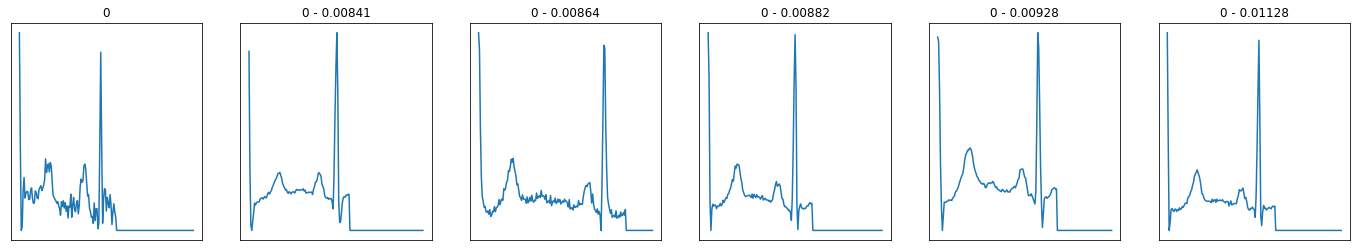

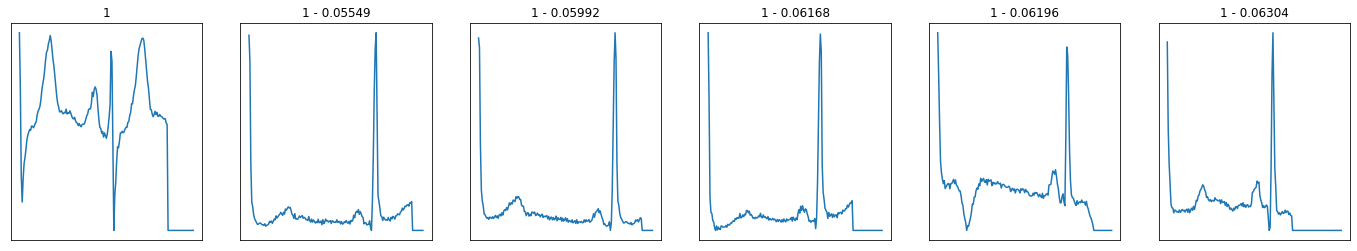

In [27]:
num_examples = 5
num_neigboors = 5
x_display, y_display = tfsim.samplers.select_examples(
    X_test, Y_test, CLASSES, 1)
nns = model.lookup(x_display, k=num_neigboors)
for idx in np.argsort(y_display):
    viz_neigbors_imgs(x_display[idx], y_display[idx],
                      nns[idx], class_mapping=ptbdb_dict)

### Apply calibration for f1

In [28]:
calibration = model.calibrate(
    X_val,
    Y_val,
    extra_metrics=["precision", "recall", "binary_accuracy", "f1"],
    verbose=1,
    calibration_metric="f1"
)


Performing NN search



Building NN list:   0%|          | 0/1165 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/1138 [00:00<?, ?it/s]


 name       value    distance    precision    recall    binary_accuracy        f1
-------  -------  ----------  -----------  --------  -----------------  --------
optimal        1   0.0641102      0.99485         1            0.99485  0.997418


### Plot Results

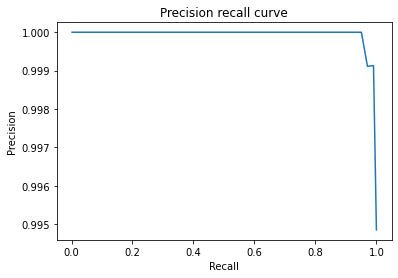

In [29]:
fig, ax = plt.subplots()
ax.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax.set_title("Precision recall curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.show()

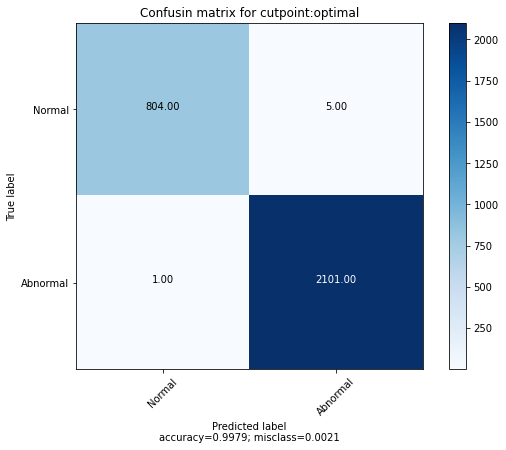

In [44]:
# used to label in images in the viz_neighbors_imgs plots
# note we added a 11th classes for unknown
labels = [*ptbdb_dict.keys()]
cutpoint = "optimal"

#No Match labels are put 0
matches = model.match(X_test, cutpoint=cutpoint, no_match_label=0)
cm = tfsim.visualization.confusion_matrix(
    matches,
    Y_test,
    labels=labels,
    normalize=False,
    title="Confusin matrix for cutpoint:%s" % cutpoint,
)

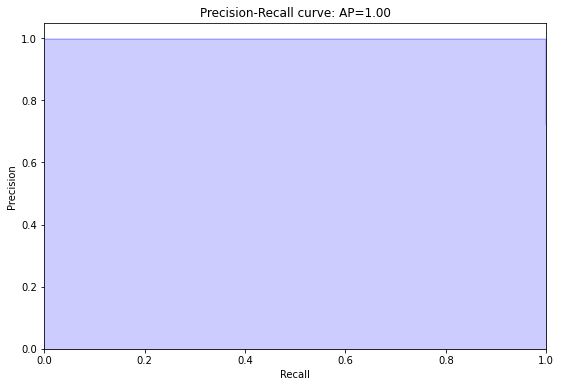

In [33]:
plot_precisionrecall(Y_test, matches)

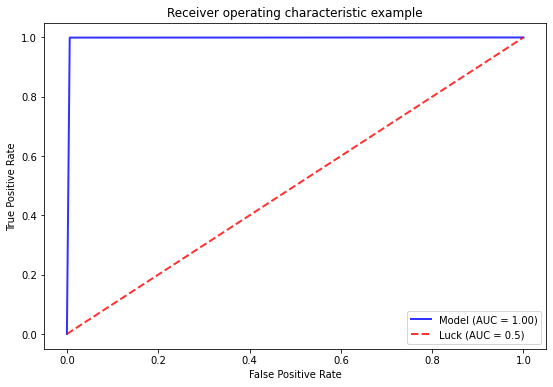

In [34]:
plot_roc(Y_test, matches)

In [ ]:
#The matching can be a bit probelmatic, as there are samples that have no NN in the cutoff distance, are therfore classless
#As mostly only a 1 or two samples have no class i just put them in on class at random. NOt the best solution...

In [35]:
matches = model.match(X_test, cutpoint=cutpoint, no_match_label=0, k=5)
f1 = f1_score(Y_test, matches, average="macro")
acc = accuracy_score(Y_test, matches)

print("Test F1 score : {:.4f}".format(np.mean(f1)))
print("Test ACC score : {:.4f}".format(np.mean(acc)))

Test F1 score : 0.9974
Test ACC score : 0.9979


In [36]:
# One can do really nice visualizations of the embedding space in tensorboard projector!
# Refresh tensorboard and go to projector you can do pca, tsne, umap under labels you can select label such you see different
# classes differentl colored. You can change from folder "train" to "validation" 
#(folder names have nothing to do with it, was just easier to save that way) on tensorboard projector upper left and you 
# will see the images of the timeseries in the embedding space o get a better idea why certain examples are closer
# to the wrong cluster

In [37]:
project_embedding(
    model, {v: k for k, v in ptbdb_dict.items()}, tensorboard_path, X_test, Y_test)
project_embedding(model, {v: k for k, v in ptbdb_dict.items(
)}, tensorboard_path, X_test, Y_test, sprite_image=True)

filtering examples:   0%|          | 0/2911 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/2 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1500 [00:00<?, ?it/s]

filtering examples:   0%|          | 0/2911 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/2 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1500 [00:00<?, ?it/s]

In [38]:
model_path = os.path.join(model_path_parent, model_name+"_"+data)
model.save(model_path, save_index=True)

INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/04-Task4\DMLCNN_ptbdbbest\assets


INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/04-Task4\DMLCNN_ptbdbbest\assets


In [40]:
%tensorboard --logdir {tensorboard_path_parent.replace(os.sep, '/')}